## نظام معتمد على التعلم العميق للوسوم النحوية العربية والأصل المعجمي والتبنؤ بالسياق

**أهم ما تمّ عمله حتى الآن**
* جمع مدونة عربية متزنة (خمسة أوعية) تعكس العربية المعاصرة النموذجية انعكاسًا يُمثّل تنوعًا للوحدات المعجمية العربية، ونسبة كثافة معجمية عالية
* منهج تأصيل معجمي موحد يُبقي القسم الكلامي
للكلمة (التوكن) على قسمه النحوي دون تغيير
* تركنا التشكيل على الكلمات مرةً، ثم أزلناها مرةً أخرى. ظهرت نتائج نماذج الكلمات إلى متجه بدون الشكيل أفضل
* إمكانية تحسين نموذج الشَّبكات العصبِيَّة المتكَرّرة بشبكات الذَّاكرة القصيرةِ-الطَّويلةِ المدى بدلا من نموذج الحقول العشوائية المشروطة
* إمكانية تحسين نموذج حقيبية الكلمات المستمرة بدلا من تخطي الكلمة، وذلك بزيادة حجم البيانات 
* استخراج الكلمات ذات العلاقة بنموذج حقيبة الكلمات المستمرة
* استخراج الكلمات المختلفة سياقيا والمتشابة/المتقابة إملائيا بنموذج بيرت 
* اعتمدنا على نموذج مدرب مسبقا لبيرت، ويحتاج بناؤه من الصفر وتدريبه وفق التعلم الموجه وقتا أطول. لاحظنا أن في النموذج المدرّب مسبقا بعض الأخطاء في نظام التفريق، وسنعمل على تحسين ذلك ببناء نظام للتفريق ثم بناء نموذج بيرت بناء عليه، وعلى بياناتنا الخاصة بالفريق

## معلومات عن المدونة (البيانات اللغوية)

-	Standard--Academic (A):	10,512 tokens (before tokenizing); 10,657 tokens (after tokenizing); 10,612 tokens (after segmenting)
-	Standard-- Khutbah (K):	10,380 tokens (before tokenizing); 10,713 tokens (after tokenizing); 13,396 tokens (after segmenting)
-	Standard--Journalism (N): 10,408 tokens (before tokenizing); 11,019 tokens (after tokenizing); 12,584 13,396 tokens (after segmenting)
-	Standard--Official-Issues (O): 10,093 tokens (before tokenizing); 10,657 tokens (after tokenizing); 12,351 tokens (after segmenting)
-	Standard--Web (W): 10,097 tokens (before tokenizing); 10,706 tokens (after tokenizing); 12,365 tokens (after segmenting)

**The whole data (Talafeef.txt): 51,490 tokens (before tokenizing); 53,752 tokens (after tokenizing); 61,308 (61,312 IDs as in Talafeef.txt) tokens (after segmenting)**

# النماذج على الترتيب مكتوبة بالإنجليزية بغية الوضوح

All models are saved in a zip folder named as NLPiffy_GUI
1. CRF Model: (crf_model.sav)
2. RNN (LSTM) Model: (RNN_model.h5)
3. RNN (N-Gram): (RNN_tag2index.pkl and RNN_word2index.pkl)
4. Skip-Gram Model: (SkipG_model.pt)
5. CBOW Model: (cbow_model.h5 and CBOW_Embeddings.npz)
6. Pretrained BERT Model (bert-model.h5)
7. BERT: (tokenized_text.npz) and (token_vecs_cat_array.npz) and (tokenized_text.pkl). All are integrated into the GUI. We created the mdoel bert-model.h5 first, then we created a list of embeddings to use it at this stage. 

### إرشادات مفيدة حول ترميز الملفات النصية
For easying the encoding: Save TXT files as ANSI encoded if you use jupyter notebook. Save TXT files as UTF-8-Bom encoded if you use colab. Save any TXT files other than our data for to be used in the GUI as UTF-16 encoded. 

In [ ]:
!pip install lazyme

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. 1. نموذج الحقول العشوائية المشروطة لتدريب واختبار تصنيف الوسوم النحوية
## Conditional Random Fields (CRF)

In [ ]:
from lazyme import per_section
import nltk 
from collections import Counter
import numpy as np
import pandas as pd

In [ ]:
dataset = pd.read_csv("/content/Talafeef.csv",usecols=['token','tpos'])
dataset.head()

,token,tpos
0,إذا,RP
1,تم,VBD
2,إجراء,N
3,صورة,N
4,شعاعية,N


In [ ]:
dataset.isnull().sum()

token    0
tpos     0
dtype: int64

In [ ]:
dataset['tpos'].apply(lambda x:type(x)).value_counts()

<class 'str'>    61313
Name: tpos, dtype: int64

In [ ]:
#end_sent_index = dataset.query('token=="." or token =="،"').index
end_sent_index = dataset.query('token=="."').index

In [ ]:
sentances=[]
dataset_tuple=[]
for i in dataset.index:
    sentances.append(tuple(dataset.iloc[i,:]))
    if dataset.loc[i,'token'] == '.':
        dataset_tuple.append(sentances)
        sentances=[]

In [ ]:
len(dataset_tuple)

1412

In [ ]:
len(end_sent_index)

1412

In [ ]:
dataset_size = np.arange(len(dataset_tuple))
train_index = np.random.choice(dataset_size, int(len(dataset_tuple)*0.8), replace=False)
test_index = np.setdiff1d(dataset_size,train_index)

In [ ]:
train_index.shape

(1129,)

In [ ]:
test_index.shape

(283,)

In [ ]:
training_sentences = [dataset_tuple[i] for i in train_index]
test_sentences = [dataset_tuple[i] for i in test_index]

In [ ]:
print (training_sentences[0])

[('ملاحظة', 'JJ'), (':', 'PUNC'), ('قد', 'RP'), ('لا', 'RP'), ('نشاهد', 'VBP'), ('القبيبات', 'N'), ('نتيجة', 'N'), ('فرط', 'N'), ('تمدد', 'VBP'), ('الأمعاء', 'N'), ('مثال', 'N'), ('2', 'CD'), ('مثال', 'N'), ('3', 'CD'), ('الصورة', 'N'), ('45', 'CD'), (':', 'PUNC'), ('تظهر', 'VBP'), ('صورتا', 'N'), ('البطن', 'N'), ('الشعاعيتين', 'N'), ('المتطابقتان', 'JJ'), ('توسع', 'N'), ('الأمعاء', 'N'), ('الغليظة', 'JJ'), ('،', 'PUNC'), ('تشاهد', 'VBP'), ('الأمعاء', 'N'), ('الغليظة', 'JJ'), ('و', 'CC'), ('ضمنها', 'N'), ('الغاز', 'N'), ('ب', 'IN'), ('اللون', 'N'), ('الأسود', 'JJR'), ('،', 'PUNC'), ('حيث', 'RB'), ('تنتفخ', 'VBP'), ('الأمعاء', 'N'), ('الغليظة', 'JJ'), ('56', 'CD'), ('سم', 'N'), ('و', 'CC'), ('تتوضع', 'VBP'), ('محيطيا', 'N'), ('،', 'PUNC'), ('و', 'CC'), ('نشاهد', 'VBP'), ('القبيبات', 'N'), ('ضمنها', 'N'), ('تظهر', 'VBP'), ('الصورة', 'N'), ('الشعاعية', 'N'), ('اليسرى', 'JJ'), ('توسع', 'N'), ('الأمعاء', 'N'), ('الغليظة', 'JJ'), ('مميزة', 'JJ'), ('ب', 'IN'), ('اللون', 'N'), ('الأخضر', 'JJR'

In [ ]:
def features(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        
        'prefix-1': sentence[index][0],
        #'prefix-2': sentence[index][:2],
        #'prefix-3': sentence[index][:3],
        #'prefix-4': sentence[index][:4],
        'suffix-1': sentence[index][-1],
        #'suffix-2': sentence[index][-2:],
        #'suffix-3': sentence[index][-3:],

        'prev_word1': '' if index == 0 else sentence[index - 1],
        
        'next_word1': '' if index == len(sentence) - 1 else sentence[index + 1],        
        
        'is_numeric': sentence[index].isdigit(),
    }

In [ ]:
from nltk.tag.util import untag
# Split the dataset for training and testing
 
def transform_to_dataset(tagged_sentences):
    X, y = [], []
 
    for tagged in tagged_sentences:
        X.append([features(untag(tagged), index) for index in range(len(tagged))])
        y.append([tag for _, tag in tagged])
 
    return X, y
 
X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(test_sentences)

print(len(X_train))     
print(len(X_test))

1129
283


In [ ]:
!pip install sklearn_crfsuite

import time
start_time = time.time()

from sklearn_crfsuite import CRF
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
 
crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
    c1=0.01,
    c2=0.01,
    max_iterations=100000,
    all_possible_transitions=True)
crf.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--- 45.149924755096436 seconds ---


In [ ]:
labels = list(crf.classes_)
labels

['JJ',
 'PUNC',
 'RP',
 'VBP',
 'N',
 'CD',
 'CC',
 'IN',
 'JJR',
 'RB',
 'DT',
 'PRP',
 'WP',
 'VBN',
 'VBD',
 'VB',
 'WRB',
 'ABBREV',
 'FW']

In [ ]:
y_pred = crf.predict(X_test)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
a = mlb.fit_transform([crf.classes_])
y_test_matrix = mlb.transform(y_test)
y_pred_matrix = mlb.transform(y_pred)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test_matrix, y_pred_matrix, target_names=crf.classes_, digits=3))

              precision    recall  f1-score   support

          JJ      0.913     0.840     0.875        25
        PUNC      0.992     1.000     0.996       252
          RP      1.000     1.000     1.000        51
         VBP      0.989     0.989     0.989        94
           N      1.000     0.750     0.857         8
          CD      0.996     1.000     0.998       265
          CC      0.950     0.925     0.938       228
          IN      0.878     0.827     0.851        52
         JJR      0.996     1.000     0.998       281
          RB      0.959     0.959     0.959        49
          DT      1.000     0.996     0.998       283
         PRP      0.954     0.937     0.945       111
          WP      0.972     0.989     0.981       178
         VBN      0.920     0.821     0.868        28
         VBD      0.917     0.807     0.858       150
          VB      0.500     0.231     0.316        13
         WRB      0.927     0.990     0.957       204
      ABBREV      0.911    

In [ ]:
import time
start_time = time.time()

from sklearn_crfsuite import metrics
 
y_pred = crf.predict(X_test)
print("Accuracy = ",metrics.flat_accuracy_score(y_test, y_pred))
print ("Recall =", metrics.flat_recall_score(y_test, y_pred, average='weighted',  labels=labels))
print ("Precision =", metrics.flat_precision_score(y_test, y_pred, average='weighted',  labels=labels))
print ("F1 =", metrics.flat_f1_score(y_test, y_pred, average='weighted',  labels=labels))

print("--- %s seconds ---" % (time.time() - start_time))

Accuracy =  0.8785732571038485
Recall = 0.8785732571038485
Precision = 0.8765083838069269
F1 = 0.8747365720484321
--- 0.1922621726989746 seconds ---


In [ ]:
y_pred = crf.predict(X_test)
print ("F1 =", metrics.flat_f1_score(y_test, y_pred, average='weighted',  labels=labels))

F1 = 0.8747365720484321


In [ ]:
sentence = 'إذا تم إجراء صورة شعاعية ل البطن و صورة شعاعية ل الصدر ب وضعية الوقوف و مازال تشخيص استرواح الصفاق غير مؤكد ف عندها يجب طلب تصوير مقطعي محوسب ل البطن .'.split()
def pos_tag(sentence):
    sentence_features = [features(sentence, index) for index in range(len(sentence))]
    return list(zip(sentence, crf.predict([sentence_features])[0]))
 
print(pos_tag(sentence))

[('إذا', 'RP'), ('تم', 'VBD'), ('إجراء', 'N'), ('صورة', 'N'), ('شعاعية', 'N'), ('ل', 'IN'), ('البطن', 'N'), ('و', 'CC'), ('صورة', 'N'), ('شعاعية', 'N'), ('ل', 'IN'), ('الصدر', 'N'), ('ب', 'IN'), ('وضعية', 'N'), ('الوقوف', 'N'), ('و', 'CC'), ('مازال', 'N'), ('تشخيص', 'N'), ('استرواح', 'N'), ('الصفاق', 'N'), ('غير', 'N'), ('مؤكد', 'JJ'), ('ف', 'CC'), ('عندها', 'RB'), ('يجب', 'VBP'), ('طلب', 'N'), ('تصوير', 'N'), ('مقطعي', 'JJ'), ('محوسب', 'N'), ('ل', 'IN'), ('البطن', 'N'), ('.', 'PUNC')]


# 1. 2. حفظ نموذج الحقول العشوائية المشروطة
## CRF

In [ ]:
import pickle
filename = 'crf_model.sav'
pickle.dump(crf, open(filename, 'wb'))

# 2. 1. نموذج الشبكات العصبية المتكررة (شبكات الذَّاكرة القصيرة-الطويلة المدى)  
## RNN (LSTM)

In [ ]:
!pip install keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from tensorflow.keras.optimizers import Adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
dataset = pd.read_csv("/content/Talafeef.csv",usecols=['token','tpos'])
dataset.head()

,token,tpos
0,إذا,RP
1,تم,VBD
2,إجراء,N
3,صورة,N
4,شعاعية,N


In [ ]:
sentances=[]
dataset_tuple=[]
for i in dataset.index:
    sentances.append(tuple(dataset.iloc[i,:]))
    #if dataset.loc[i,'token'] == '.':
    if dataset.loc[i,'token'] == "." or dataset.loc[i,'token'] == "،":
        dataset_tuple.append(sentances)
        sentances=[]

In [ ]:
dataset_tuple[0]

[('إذا', 'RP'),
 ('تم', 'VBD'),
 ('إجراء', 'N'),
 ('صورة', 'N'),
 ('شعاعية', 'N'),
 ('ل', 'IN'),
 ('البطن', 'N'),
 ('و', 'CC'),
 ('صورة', 'N'),
 ('شعاعية', 'N'),
 ('ل', 'IN'),
 ('الصدر', 'N'),
 ('ب', 'IN'),
 ('وضعية', 'N'),
 ('الوقوف', 'N'),
 ('و', 'CC'),
 ('مازال', 'VBD'),
 ('تشخيص', 'N'),
 ('استرواح', 'N'),
 ('الصفاق', 'N'),
 ('غير', 'N'),
 ('مؤكد', 'JJ'),
 ('ف', 'CC'),
 ('عندها', 'RB'),
 ('يجب', 'VBP'),
 ('طلب', 'N'),
 ('تصوير', 'N'),
 ('مقطعي', 'JJ'),
 ('محوسب', 'JJ'),
 ('ل', 'IN'),
 ('البطن', 'N'),
 ('.', 'PUNC')]

In [ ]:
sentences, sentence_tags =[], [] 
for tagged_sentence in dataset_tuple:
    sentence, tags = zip(*tagged_sentence)
    sentences.append(np.array(sentence))
    sentence_tags.append(np.array(tags))

In [ ]:
sentences[2]

array(['و', 'حاليا', 'ف', 'إن', 'معظم', 'المرضى', 'غير', 'المستقرين',
       'الذين', 'يشك', 'لديهم', 'ب', 'استرواح', 'الصفاق', 'يخضعون',
       'مباشرة', 'ل', 'التصوير', 'المقطعي', 'المحوسب', '.'], dtype='<U9')

In [ ]:
sentence_tags[2]

array(['CC', 'N', 'CC', 'RP', 'JJ', 'N', 'N', 'JJ', 'WP', 'VBP', 'RB',
       'IN', 'N', 'N', 'VBP', 'JJ', 'IN', 'N', 'JJ', 'JJ', 'PUNC'],
      dtype='<U4')

In [ ]:
len(sentences[2]), len(sentence_tags[2])

(21, 21)

In [ ]:
(train_sentences, 
 test_sentences, 
 train_tags, 
 test_tags) = train_test_split(sentences, sentence_tags, test_size=0.2)

In [ ]:
words, tags = set([]), set([])
 
for s in train_sentences:
    for w in s:
        words.add(w)
 
for ts in train_tags:
    for t in ts:
        tags.add(t)
 
word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs
 
tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0  # The special value used to padding

In [ ]:
len(word2index)

10368

In [ ]:
tag2index

{'-PAD-': 0,
 'ABBREV': 5,
 'CC': 15,
 'CD': 18,
 'DT': 9,
 'FW': 12,
 'IN': 3,
 'JJ': 13,
 'JJR': 14,
 'N': 19,
 'PRP': 2,
 'PUNC': 1,
 'RB': 11,
 'RP': 16,
 'VB': 6,
 'VBD': 17,
 'VBN': 4,
 'VBP': 7,
 'WP': 10,
 'WRB': 8}

In [ ]:
train_sentences_X, test_sentences_X, train_tags_y, test_tags_y = [], [], [], []
 
for s in train_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    train_sentences_X.append(s_int)
 
for s in test_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    test_sentences_X.append(s_int)
 
for s in train_tags:
    train_tags_y.append([tag2index[t] for t in s])
 
for s in test_tags:
    test_tags_y.append([tag2index[t] for t in s])

In [ ]:
print(train_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])

[139, 3795, 798, 4301, 5898, 3295, 8123, 5846]
[10250, 8771, 5199, 8580, 10087, 4916, 6297, 1, 4711, 5360, 1, 2723, 6796, 217, 1, 7979, 1628, 3350, 1, 1, 4581]
[19, 17, 14, 19, 3, 18, 19, 1]
[15, 19, 15, 16, 13, 19, 19, 13, 10, 7, 11, 3, 19, 19, 7, 13, 3, 19, 13, 13, 1]


In [ ]:
MAX_LENGTH = max([len(s) for s in train_sentences_X])
MAX_LENGTH

2328

In [ ]:
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

In [ ]:
len(train_sentences_X[0]),len(train_sentences_X[5])

(2328, 2328)

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2328, 128)         1327104   
                                                                 
 bidirectional (Bidirectiona  (None, 2328, 512)        788480    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 2328, 20)         10260     
 ibuted)                                                         
                                                                 
 activation (Activation)     (None, 2328, 20)          0         
                                                                 
Total params: 2,125,844
Trainable params: 2,125,844
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [ ]:
cat_train_tags_y = to_categorical(train_tags_y, len(tag2index))

In [ ]:
cat_train_tags_y.shape

(2748, 2328, 20)

In [ ]:
model.fit(train_sentences_X, to_categorical(train_tags_y, len(tag2index)), batch_size=128, epochs=40, validation_split=0.2)

Epoch 1/40
18/18 [==============================] - 15s 647ms/step - loss: 0.7219 - accuracy: 0.9343 - val_loss: 0.0655 - val_accuracy: 0.9930
Epoch 2/40
18/18 [==============================] - 11s 596ms/step - loss: 0.0445 - accuracy: 0.9920 - val_loss: 0.0253 - val_accuracy: 0.9932
Epoch 3/40
18/18 [==============================] - 11s 593ms/step - loss: 0.0242 - accuracy: 0.9930 - val_loss: 0.0189 - val_accuracy: 0.9947
Epoch 4/40
18/18 [==============================] - 11s 593ms/step - loss: 0.0211 - accuracy: 0.9943 - val_loss: 0.0171 - val_accuracy: 0.9954
Epoch 5/40
18/18 [==============================] - 11s 595ms/step - loss: 0.0198 - accuracy: 0.9948 - val_loss: 0.0163 - val_accuracy: 0.9958
Epoch 6/40
18/18 [==============================] - 11s 592ms/step - loss: 0.0230 - accuracy: 0.9948 - val_loss: 0.0161 - val_accuracy: 0.9955
Epoch 7/40
18/18 [==============================] - 11s 593ms/step - loss: 0.0221 - accuracy: 0.9949 - val_loss: 0.0172 - val_accuracy: 0.9957

In [ ]:
scores = model.evaluate(test_sentences_X, to_categorical(test_tags_y, len(tag2index)))
print(f"{model.metrics_names[1]}: {scores[1] * 100}")

22/22 [==============================] - 3s 120ms/step - loss: 0.0076 - accuracy: 0.9980
accuracy: 99.80045557022095


In [ ]:
test_samples = [
    "إذا تم إجراء صورة شعاعية ل البطن و صورة شعاعية ل الصدر ب وضعية الوقوف و مازال تشخيص استرواح الصفاق غير مؤكد ف عندها يجب طلب تصوير مقطعي محوسب ل البطن .".split(),
]
print(test_samples)

[['إذا', 'تم', 'إجراء', 'صورة', 'شعاعية', 'ل', 'البطن', 'و', 'صورة', 'شعاعية', 'ل', 'الصدر', 'ب', 'وضعية', 'الوقوف', 'و', 'مازال', 'تشخيص', 'استرواح', 'الصفاق', 'غير', 'مؤكد', 'ف', 'عندها', 'يجب', 'طلب', 'تصوير', 'مقطعي', 'محوسب', 'ل', 'البطن', '.']]


In [ ]:
test_samples_X = []
for s in test_samples:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
    test_samples_X.append(s_int)
 
test_samples_X = pad_sequences(test_samples_X, maxlen=MAX_LENGTH, padding='post')
print(test_samples_X)

[[ 864  184 2720 ...    0    0    0]]


In [ ]:
predictions = model.predict(test_samples_X)
print(predictions, predictions.shape)

[[[2.1651749e-02 1.6768884e-02 2.2896182e-02 ... 7.2434001e-02
   3.6305372e-02 1.1764008e-02]
  [2.0008868e-02 1.6128410e-02 2.5209881e-02 ... 1.1038224e-01
   4.4337686e-02 4.8819020e-02]
  [7.6984437e-03 7.0730331e-03 3.2513961e-03 ... 1.6929112e-02
   7.3709767e-03 8.4192204e-01]
  ...
  [9.9999321e-01 5.6120581e-07 3.4945234e-07 ... 7.6583298e-08
   8.3404308e-07 7.3564919e-08]
  [9.9999082e-01 6.4347444e-07 4.8504415e-07 ... 1.0428392e-07
   1.1091902e-06 7.7190236e-08]
  [9.9998808e-01 7.1799349e-07 6.2587554e-07 ... 1.3327907e-07
   1.3850819e-06 8.1466119e-08]]] (1, 2328, 20)


In [ ]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences

In [ ]:
print(logits_to_tokens(predictions, {i: t for t, i in tag2index.items()})[0])

['RP', 'VBP', 'N', 'N', 'N', 'IN', 'N', 'CC', 'N', 'N', 'IN', 'N', 'IN', 'N', 'N', 'CC', 'N', 'N', 'N', 'N', 'N', 'JJ', 'CC', 'VBP', 'VBP', 'N', 'N', 'JJ', 'N', 'IN', 'N', 'PUNC', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '

In [ ]:
from keras import backend as K
 
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy', ignore_class_accuracy(0)])
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2328, 128)         1327104   
                                                                 
 bidirectional_1 (Bidirectio  (None, 2328, 512)        788480    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 2328, 20)         10260     
 tributed)                                                       
                                                                 
 activation_1 (Activation)   (None, 2328, 20)          0         
                                                                 
Total params: 2,125,844
Trainable params: 2,125,844
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_sentences_X, to_categorical(train_tags_y, len(tag2index)), batch_size=128, epochs=40, validation_split=0.2)

Epoch 1/40
18/18 [==============================] - 15s 658ms/step - loss: 0.6353 - accuracy: 0.9921 - ignore_accuracy: 0.0052 - val_loss: 0.0861 - val_accuracy: 0.9929 - val_ignore_accuracy: 0.0000e+00
Epoch 2/40
18/18 [==============================] - 11s 594ms/step - loss: 0.0695 - accuracy: 0.9919 - ignore_accuracy: 8.7904e-05 - val_loss: 0.0507 - val_accuracy: 0.9932 - val_ignore_accuracy: 0.0000e+00
Epoch 3/40
18/18 [==============================] - 11s 597ms/step - loss: 0.0424 - accuracy: 0.9920 - ignore_accuracy: 1.1932e-04 - val_loss: 0.0233 - val_accuracy: 0.9932 - val_ignore_accuracy: 0.0000e+00
Epoch 4/40
18/18 [==============================] - 11s 594ms/step - loss: 0.0245 - accuracy: 0.9930 - ignore_accuracy: 0.2669 - val_loss: 0.0195 - val_accuracy: 0.9944 - val_ignore_accuracy: 0.3546
Epoch 5/40
18/18 [==============================] - 11s 597ms/step - loss: 0.0215 - accuracy: 0.9940 - ignore_accuracy: 0.3812 - val_loss: 0.0175 - val_accuracy: 0.9948 - val_ignore_ac

In [ ]:
predictions = model.predict(test_samples_X)
print(logits_to_tokens(predictions, {i: t for t, i in tag2index.items()}))

[['VBP', 'N', 'N', 'N', 'N', 'IN', 'N', 'CC', 'N', 'N', 'IN', 'N', 'IN', 'N', 'N', 'CC', 'N', 'N', 'N', 'N', 'N', 'JJ', 'CC', 'VBP', 'VBP', 'N', 'N', 'JJ', 'JJ', 'IN', 'N', 'PUNC', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', 

# 2. 2. حفظ نموذج الشبكات العصبية التكراراية
## RNN (LSTM)

In [ ]:
# Save RNN Model
model.save("RNN_model.h5")

In [ ]:
import pickle
a_file = open("RNN_tag2index.pkl", "wb")
pickle.dump(tag2index, a_file)
a_file.close()

In [ ]:
b_file = open("RNN_word2index.pkl", "wb")
pickle.dump(word2index, b_file)
b_file.close()

# 3. 1. نموذج الكلمة إلى متجه (تخطي الكلمة) 
## Word2Vec (Skip-Gram Model)

In [ ]:
# يجب إعادة التشغيل بعد التنصيب
#!pip install allennl
#!pip install --upgrade allennlp
!pip install allennlp==2.5.0
!pip install google-cloud-storag
!pip install overrides
!pip install python-bidi
!pip install arabic_reshaper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 681 kB 4.2 MB/s 
     |████████████████████████████████| 592 kB 79.7 MB/s 
     |████████████████████████████████| 1.2 MB 54.6 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 2.2 MB 59.6 MB/s 
     |████████████████████████████████| 125 kB 83.8 MB/s 
     |████████████████████████████████| 804.1 MB 2.3 kB/s 
     |████████████████████████████████| 1.8 MB 55.4 MB/s 
     |████████████████████████████████| 132 kB 77.5 MB/s 
     |████████████████████████████████| 17.4 MB 20.2 MB/s 
     |████████████████████████████████| 103 kB 75.8 MB/s 
     |████████████████████████████████| 12.1 MB 58.0 MB/s 
     |████████████████████████████████| 22.3 MB 105 kB/s 
     |████████████████████████████████| 167 kB 75.3 MB/s 
     |████████████████████████████████| 79 kB 9.0 MB/s 
     |███████████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement google-cloud-storag (from versions: none)
ERROR: No matching distribution found for google-cloud-storag
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import random
from collections import Counter
import numpy as np
import torch
import torch.optim as optim
from allennlp.common.file_utils import cached_path
from allennlp.data.data_loaders import SimpleDataLoader
from allennlp.data.dataset_readers.dataset_reader import DatasetReader
from allennlp.data.fields import LabelField
from allennlp.data.instance import Instance
from allennlp.data.vocabulary import Vocabulary
from allennlp.models import Model
from allennlp.modules.token_embedders import Embedding
from allennlp.training import GradientDescentTrainer
from overrides import overrides
from scipy.stats import spearmanr
from torch.nn import CosineSimilarity
from torch.nn import functional
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
%matplotlib inline
from bidi.algorithm import get_display
import arabic_reshaper

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
@DatasetReader.register("skip_gram")
class SkipGramReader(DatasetReader):
    def __init__(self, window_size=5, vocab: Vocabulary=None):
        """A DatasetReader for reading a plain text corpus and producing instances
        for the SkipGram model.
        When vocab is not None, this runs sub-sampling of frequent words as described
        in (Mikolov et al. 2013).
        """
        super().__init__()
        self.window_size = window_size
        self.reject_probs = None
        if vocab:
            self.reject_probs = {}
            threshold = 1.e-3
            token_counts = vocab._retained_counter['token_in']  # HACK
            total_counts = sum(token_counts.values())
            for _, token in vocab.get_index_to_token_vocabulary('token_in').items():
                counts = token_counts[token]
                if counts > 0:
                    normalized_counts = counts / total_counts
                    reject_prob = 1. - math.sqrt(threshold / normalized_counts)
                    reject_prob = max(0., reject_prob)
                else:
                    reject_prob = 0.
                self.reject_probs[token] = reject_prob

    def _subsample_tokens(self, tokens):
        """Given a list of tokens, runs sub-sampling.
        Returns a new list of tokens where rejected tokens are replaced by Nones.
        """
        new_tokens = []
        for token in tokens:
            reject_prob = self.reject_probs.get(token, 0.)
            if random.random() <= reject_prob:
                new_tokens.append(None)
            else:
                new_tokens.append(token)

        return new_tokens

    @overrides
    def _read(self, file_path: str):
        with open(cached_path(file_path), "r") as text_file:
            for line in text_file:
                tokens = line.strip().split(' ')
                tokens = tokens[:1000000]  # TODO: remove

                if self.reject_probs:
                    tokens = self._subsample_tokens(tokens)
                    print(tokens[:200])  # for debugging

                for i, token in enumerate(tokens):
                    if token is None:
                        continue

                    token_in = LabelField(token, label_namespace='token_in')

                    for j in range(i - self.window_size, i + self.window_size + 1):
                        if j < 0 or i == j or j > len(tokens) - 1:
                            continue

                        if tokens[j] is None:
                            continue

                        token_out = LabelField(tokens[j], label_namespace='token_out')
                        yield Instance({'token_in': token_in, 'token_out': token_out})

In [ ]:
EMBEDDING_DIM = 256
BATCH_SIZE = 256
CUDA_DEVICE = -1

In [ ]:
class SkipGramModel(Model):
    def __init__(self, vocab, embedding_in):
        super().__init__(vocab)
        self.embedding_in = embedding_in
        self.linear = torch.nn.Linear(
            in_features=EMBEDDING_DIM,
            out_features=vocab.get_vocab_size('token_out'),
            bias=False)

    def forward(self, token_in, token_out):
        embedded_in = self.embedding_in(token_in)
        logits = self.linear(embedded_in)
        loss = functional.cross_entropy(logits, token_out)

        return {'loss': loss}

In [ ]:
def get_related(token: str, embedding: Model, vocab: Vocabulary, num_synonyms: int = 10):
    """Given a token, return a list of top N most similar words to the token."""
    token_id = vocab.get_token_index(token, 'token_in')
    token_vec = embedding.weight[token_id]
    cosine = CosineSimilarity(dim=0)
    sims = Counter()

    for index, token in vocab.get_index_to_token_vocabulary('token_in').items():
        sim = cosine(token_vec, embedding.weight[index]).item()
        sims[token] = sim

    return sims.most_common(num_synonyms)

In [ ]:
reader = SkipGramReader()
talafeef = reader.read("/content/Talafeef--Seg.txt")

In [ ]:
talafeef = list(talafeef)
print(len(talafeef))

Your label namespace was 'token_in'. We recommend you use a namespace ending with 'labels' or 'tags', so we don't add UNK and PAD tokens by default to your vocabulary.  See documentation for `non_padded_namespaces` parameter in Vocabulary.
Your label namespace was 'token_out'. We recommend you use a namespace ending with 'labels' or 'tags', so we don't add UNK and PAD tokens by default to your vocabulary.  See documentation for `non_padded_namespaces` parameter in Vocabulary.


613100


In [ ]:
vocab = Vocabulary.from_instances(
    talafeef, min_count={'token_in': 2, 'token_out': 2},max_vocab_size=100000)

building vocab: 100%|##########| 613100/613100 [00:00<00:00, 693782.89it/s]


In [ ]:
data_loader = SimpleDataLoader(talafeef, batch_size=BATCH_SIZE)
data_loader.index_with(vocab)

In [ ]:
vocab.get_vocab_size

<bound method Vocabulary.get_vocab_size of Vocabulary with namespaces:  token_in, Size: 11737 || token_out, Size: 11737 || Non Padded Namespaces: {'*tags', '*labels'}>

In [ ]:
embedding_in = Embedding(num_embeddings=vocab.get_vocab_size('token_in'),
                         embedding_dim=EMBEDDING_DIM)

In [ ]:
model = SkipGramModel(vocab=vocab,
                      embedding_in=embedding_in)

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
trainer = GradientDescentTrainer(
    model=model,
    optimizer=optimizer,
    data_loader=data_loader,
    num_epochs=5,
    cuda_device=-1)

In [ ]:
trainer.train()

batch_loss: 8.9262, loss: 8.3163 ||: 100%|##########| 2395/2395 [03:37<00:00, 11.01it/s]
batch_loss: 8.4235, loss: 7.2847 ||: 100%|##########| 2395/2395 [03:41<00:00, 10.83it/s]
batch_loss: 8.1600, loss: 7.0730 ||: 100%|##########| 2395/2395 [03:36<00:00, 11.06it/s]
batch_loss: 7.8221, loss: 6.9099 ||: 100%|##########| 2395/2395 [03:34<00:00, 11.15it/s]
batch_loss: 7.6173, loss: 6.7057 ||: 100%|##########| 2395/2395 [03:32<00:00, 11.27it/s]


{'best_epoch': 4,
 'epoch': 4,
 'peak_gpu_0_memory_MB': 0,
 'peak_worker_0_memory_MB': 1207.1796875,
 'training_duration': '0:18:02.744570',
 'training_gpu_0_memory_MB': 0.0,
 'training_loss': 6.705664099332933,
 'training_worker_0_memory_MB': 1207.1796875}

# 3. 2. حفظ نموذج تخطي الكلمة
## Save Skip-Gram Model

In [ ]:
torch.save(model, r"SkipG_model.pt")
#with open("model.th", 'wb') as f:
#    torch.save(model.state_dict(), f)
#trainer.save('model.pt')

In [ ]:
print(get_related('العلوم', embedding_in, vocab))

[('العلوم', 1.0), ('الشمولي', 0.8552536964416504), ('ذعار', 0.8509091138839722), ('البعد', 0.8491868376731873), ('تهيئتهم', 0.8395654559135437), ('تعليم', 0.8363445401191711), ('المركب', 0.8340771794319153), ('القطاعين', 0.829744815826416), ('المطيري', 0.8285819292068481), ('التحقق', 0.8283525109291077)]


In [ ]:
print(get_related('محمد', embedding_in, vocab))

[('محمد', 1.0), ('بارك', 0.7823770046234131), ('رسولك', 0.7554547190666199), ('آله', 0.7547944784164429), ('نبينا', 0.7288878560066223), ('إبراهيم', 0.7264019250869751), ('عبدك', 0.7123834490776062), ('رسوله', 0.6960672736167908), ('صل', 0.6841068863868713), ('الرسول', 0.6772745251655579)]


In [ ]:
print(get_related('السعودية', embedding_in, vocab))

[('السعودية', 1.0), ('العربية', 0.8364354968070984), ('المملكة', 0.804949939250946), ('ملك', 0.7140816450119019), ('سعود', 0.6986318826675415), ('عبدالعزيز', 0.6788314580917358), ('الحكم', 0.6616754531860352), ('الاطلاع', 0.6601696610450745), ('آل', 0.6568835973739624), ('فهد', 0.6204685568809509)]


In [ ]:
print(get_related('النظام', embedding_in, vocab))

[('النظام', 1.0), ('أحكام', 0.7821226716041565), ('تعديل', 0.7678943276405334), ('الأساسي', 0.7438188791275024), ('الخدمة', 0.705679178237915), ('يبين', 0.7048802375793457), ('المهام', 0.6982794404029846), ('السابعة', 0.6963353157043457), ('الرسمية', 0.6941937208175659), ('اللائحة', 0.6828559041023254)]


In [ ]:
print(get_related('الشباب', embedding_in, vocab))

[('الشباب', 1.0), ('مهارات', 0.8671875596046448), ('العاطفية', 0.8505003452301025), ('التغيير', 0.8454479575157166), ('الحكومي', 0.8435890674591064), ('القطاعين', 0.8402720093727112), ('الموجودة', 0.8372607827186584), ('المهارة', 0.8346027135848999), ('التحديث', 0.834582507610321), ('المنظمات', 0.8308627605438232)]


In [ ]:
token_id = vocab.get_token_index("الله", 'token_in')
token_vec = embedding_in.weight[token_id]

In [ ]:
cosine = CosineSimilarity(dim=0)

In [ ]:
vocab.get_vocab_size

<bound method Vocabulary.get_vocab_size of Vocabulary with namespaces:  token_in, Size: 11737 || token_out, Size: 11737 || Non Padded Namespaces: {'*tags', '*labels'}>

In [ ]:
import numpy as np
np.unique(np.array(talafeef))

array(['token_in', 'token_out'], dtype='<U9')

In [ ]:
len(talafeef)

613100

In [ ]:
vocab.get_vocab_size

<bound method Vocabulary.get_vocab_size of Vocabulary with namespaces:  token_in, Size: 11737 || token_out, Size: 11737 || Non Padded Namespaces: {'*tags', '*labels'}>

In [ ]:
vocab.get_token_to_index_vocabulary('token_in').items()

dict_items([('@@PADDING@@', 0), ('@@UNKNOWN@@', 1), ('و', 2), ('،', 3), ('ب', 4), ('ل', 5), ('.', 6), ('في', 7), ('من', 8), ('على', 9), ('أن', 10), ('الله', 11), ('ف', 12), ('ما', 13), ('لا', 14), ('إلى', 15), (':', 16), ('المادة', 17), ('عن', 18), ('أو', 19), ('هذا', 20), ('التي', 21), ('ذلك', 22), ('مجلس', 23), ('إن', 24), ('-', 25), ('كل', 26), ('هو', 27), ('هذه', 28), (')', 29), ('عليه', 30), ('(', 31), ('مع', 32), ('الصورة', 33), ('الأمعاء', 34), ('اللهم', 35), ("''", 36), ('الذي', 37), ('بعد', 38), ('قد', 39), ('النظام', 40), ('تظهر', 41), ('الوزراء', 42), ('إلا', 43), ('له', 44), ('هي', 45), ('/', 46), ('الملك', 47), ('سلم', 48), ('قال', 49), ('كما', 50), ('إذا', 51), ('كان', 52), ('رئيس', 53), ('صلى', 54), ('بين', 55), ('يكون', 56), ('ك', 57), ('المجلس', 58), ('أكثر', 59), ('الدولة', 60), ('أي', 61), ('حيث', 62), ('شكل', 63), ('المنطقة', 64), ('الهيئة', 65), ('غير', 66), ('أنه', 67), ('البطن', 68), ('الشعاعية', 69), ('تكون', 70), ('الذين', 71), ('يا', 72), ('لم', 73), ('العمل',

In [ ]:
get_related("محمد",embedding_in,vocab)

[('محمد', 1.0),
 ('بارك', 0.7823770046234131),
 ('رسولك', 0.7554547190666199),
 ('آله', 0.7547944784164429),
 ('نبينا', 0.7288878560066223),
 ('إبراهيم', 0.7264019250869751),
 ('عبدك', 0.7123834490776062),
 ('رسوله', 0.6960672736167908),
 ('صل', 0.6841068863868713),
 ('الرسول', 0.6772745251655579)]

In [ ]:
vocab.get_vocab_size("token_out")

11737

In [ ]:
embedding_in.weight.shape

torch.Size([11737, 256])

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca_components = pca.fit_transform(embedding_in.weight.detach().numpy())

In [ ]:
pca_components[0:50].shape

(50, 2)

Text(0, 0.5, 'PCA2')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


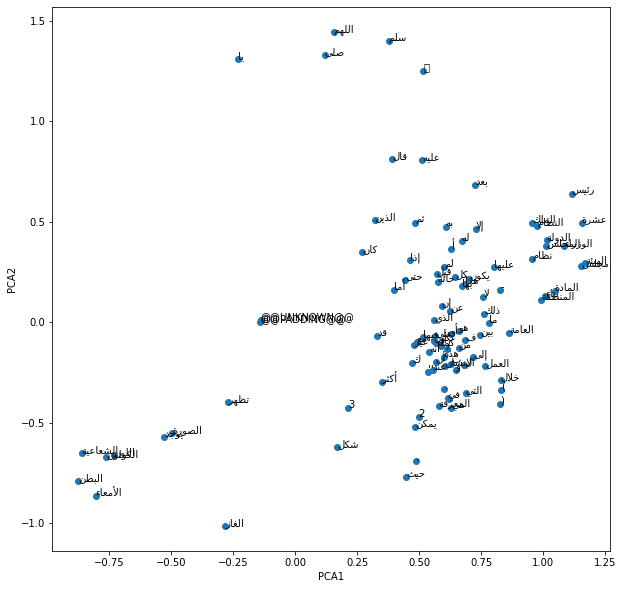

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
arabic_stopwords = stopwords.words("arabic")
plt.figure(figsize=(10,10))
labels=[vocab.get_token_from_index(i,'token_in') for i in range(100) if i not in arabic_stopwords ]
plt.scatter(pca_components[:100,0],pca_components[:100,1],cmap='plasma')
for i in range(100):
  xword = arabic_reshaper.reshape(labels[i])
  artext = get_display(xword)
  plt.annotate(artext,(pca_components[i,0],pca_components[i,1]))
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# 4. 1. نموذج الكلمة إلى متجه (حقيبة الكلمات المستمرة)
## Word2Vec (CBOW model)

In [ ]:
import numpy as np
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import Counter

In [ ]:
data=open("/content/Talafeef--Seg.txt",'r')
talafeef_data = [text for text in data if text.count(' ') >= 2]

In [ ]:
talafeef_data[0]

'\ufeffإذا تم إجراء صورة شعاعية ل البطن و صورة شعاعية ل الصدر ب وضعية الوقوف و مازال تشخيص استرواح الصفاق غير مؤكد ف عندها يجب طلب تصوير مقطعي محوسب ل البطن . يعرض التصوير المقطعي المحوسب المريض ل كمية أكبر من الإشعاع لكنه سيظهر ب وضوح وجود الغاز ( السهم الأبيض ) و قد يشخص السبب المستبطن . و حاليا ف إن معظم المرضى غير المستقرين الذين يشك لديهم ب استرواح الصفاق يخضعون مباشرة ل التصوير المقطعي المحوسب . 24 أ A D مثال 2 مثال 3 الصورة 24 : صورتان شعاعيتان ل البطن متطابقتان تظهران استرواح صفاق كبير . يوجد عرى معوية يحددها خارجيا غاز من كلا الجانبين ب شكل يتوافق مع علامة Rigler . تظهر الصورة اليمنى المناطق التي تكون فيها علامة Rigler أكثر وضوحا ب لون بني و فيروزي لمعة الأمعاء معلمة ب لون بني أما الغاز الحر الذي يحدد جدار الأمعاء خارجيا معلم ب لون فيروزي صورتان شعاعيتان متطابقتان تظهران استرواح صفاق كبير . يوجد عرى معوية يحددها خارجيا غاز من كلا الجانبين ب شكل يتوافق مع علامة Rigler تظهر الصورة اليمنى المناطق حيث يكون استرواح الصفاق أكثر وضوحا ب اللون الفيروزي و لمعة الأمعاء معلمة ب اللون الب

In [ ]:
vectorize = Tokenizer()
vectorize.fit_on_texts(talafeef_data)
talafeef_data = vectorize.texts_to_sequences(talafeef_data)
total_vocab = sum(len(s) for s in talafeef_data)
word_count = len(vectorize.word_index) + 1
window_size = 2

In [ ]:
word_count

11709

In [ ]:
total_vocab

58921

In [ ]:
def cbow_model(data, window_size, total_vocab):
    total_length = window_size*2
    for text in data:
        text_len = len(text)
        for idx, word in enumerate(text):
            context_word = []
            target   = []            
            begin = idx - window_size
            end = idx + window_size + 1
            context_word.append([text[i] for i in range(begin, end) if 0 <= i < text_len and i != idx])
            target.append(word)
            contextual = sequence.pad_sequences(context_word, maxlen=total_length)
            final_target = np_utils.to_categorical(target, total_vocab)
            yield(contextual, final_target)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=total_vocab, output_dim=100, input_length=window_size*2))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(100,)))
model.add(Dense(total_vocab, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
for i in range(10):
    cost = 0
    for x, y in cbow_model(talafeef_data, window_size, total_vocab):
        cost += model.train_on_batch(x, y)
    print(i, cost)

0 527246.8477202579
1 477937.85107502155
2 430240.111217184
3 380979.65325200843
4 336318.94472453475
5 297146.7985666318
6 263352.82523858733
7 233205.26750058917
8 206532.72101084254
9 182930.59666882927


In [ ]:
model.summary()

# 4. 2. حفظ نموذج حقيبة الكلمات المستمرة
## Save CBOW Model 

In [ ]:
model.save("cbow_model.h5")

In [ ]:
weights = model.get_weights()[0]
w2v_my = {}

for word, index in vectorize.word_index.items():
    w2v_my[word] = weights[index]

np.savez('CBOW_Embeddings.npz', **w2v_my)
embeddings = np.load('CBOW_Embeddings.npz')

In [ ]:
embeddings["الله"]

In [ ]:
def get_related(token: str, num_synonyms: int = 10):
    """Given a token, return a list of top N most similar words to the token."""
    token_vec = w2v_my[token]
    sims = Counter()

    for w,vec in w2v_my.items():
        sim = np.dot(token_vec, vec)/(np.linalg.norm(token_vec) * np.linalg.norm(vec))
        sims[w] = sim

    return sims.most_common(num_synonyms)

In [ ]:
get_related("أشعة",10)

In [ ]:
get_related("مرض",10)

In [ ]:
get_related("التقنية",10)

In [ ]:
np.array(list(w2v_my.values())).shape

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
%matplotlib inline
from bidi.algorithm import get_display
import arabic_reshaper

In [ ]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(np.array(list(w2v_my.values())))

In [ ]:
arabic_stopwords = stopwords.words("arabic")
w2v_my_no_stop=dict()
for key,value in w2v_my.items():
  if key not in arabic_stopwords:
    w2v_my_no_stop[key]=value

In [ ]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(np.array(list(w2v_my_no_stop.values())))
plt.figure(figsize=(10,10))
labels= list(embeddings.keys())[:100]
plt.scatter(pca_components[:100,0],pca_components[:100,1],cmap='plasma')
for i in range(100):
  xword = arabic_reshaper.reshape(labels[i])
  artext = get_display(xword)
  plt.annotate(artext,(pca_components[i,0],pca_components[i,1]))
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# 5.1. BERT

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import logging
import glob
import os
#from bert_function import bert_processing, get_related
import matplotlib.pyplot as plt
%matplotlib inline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
! curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
! sudo apt-get install git-lfs
! git lfs install
!  clone https://huggingface.co/aubmindlab/bert-base-arabertv2
! tar -C ./MODEL_NAME -zxvf /content/bert-base-arabertv02/tf1_model.tar.gz

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following packages will be upgraded:
  git-lfs
1 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Need to get 7,168 kB of archives.
After this operation, 7,962 kB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 3.2.0 [7,168 kB]
Fetched 7,168 kB in 1s (8,618 kB/s)
debconf: unable to initiali

In [ ]:
! pip install pyarabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 14.7 MB/s 


In [ ]:
! git clone https://github.com/aub-mind/arabert.git

Cloning into 'arabert'...
remote: Enumerating objects: 595, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 595 (delta 37), reused 43 (delta 29), pack-reused 535
Receiving objects: 100% (595/595), 9.14 MiB | 11.57 MiB/s, done.
Resolving deltas: 100% (338/338), done.


In [ ]:
! pip install farasapy
from farasa.segmenter import FarasaSegmenter 
from arabert.preprocess import ArabertPreprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

arabert_prep = ArabertPreprocessor(model_name=model_name)

Downloading:   0%|          | 0.00/611 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/720k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS

100%|██████████| 241M/241M [00:13<00:00, 18.5MiB/s]


[2022-09-23 20:43:52,414 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:
with open("/content/Dataset-UFT16-BERT.txt",'r', encoding='utf-16') as f:
    dataset_tokens = f.read()

tokens = dataset_tokens.split(" ")
number_of_tokens = len(tokens)

In [ ]:
preprocessed_text = arabert_prep.preprocess(dataset_tokens)

In [ ]:
preprocessed_text.split(".")[0]

'عام جديد و وقف +ة محاسب +ة '

In [ ]:
segmenter = FarasaSegmenter(interactive=True)
segmented = segmenter.segment(preprocessed_text)

[2022-09-23 20:44:42,255 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:
segmented

'عام جديد و وقف + +ة محاسب + +ة . ال + شيخ صالح بن عبدالله بن حميد . تاريخ ال + خطب + +ة . ال + خطب + +ة ال + أولى . ال + حمد ل الله ال + حمد ل الله تفرد ب ال + عز و ال + قهر و ال + كبرياء و استأثر ب ال + ملك و ال + تدبير و ال + بقاء قهر ال + خلق ب ما كتب علي + ه من ال + فناء أحمد + ه سبحان + ه والى ب ال + إنعام ال + نعم ال + متكاثر + +ة و حذر ب ال + انتقام ب ال + نقم ال + قاهر + +ة و أشهد أن لا إله إلا الله وحد + ه لا شريك ل + + ه ل + + ه ال + حمد في ال + أولى و ال + آخر + +ة و أشهد أن سيد + نا و نبي + نا محمد + ا عبد الله و رسول + ه أيد + ه ب ال + حجج ال + ظاهر + +ة و ال + براهين ال + باهر + +ة صلى الله و سلم و بارك علي + ه و على آله و أصحاب + ه ال + نجوم ال + زاهر + +ة و ال + كواكب ال + سائر + +ة و ال + تابع + ين و من تبع + هم ب إحسان و سلم تسليم + ا كثير + ا مزيد + ا لا تحصر + ه حاصر + +ة . أما بعد ف أوصى + كم أيها ال + ناس و نفس + ي ب تقوى الله ف اتق + و+أ الله رحم + كم الله و حاسب + و+أ أنفس + كم ف من حاسب نفس + ه عرف ب ليل + ه و ال + ناس نائم + ون و ب نهار + ه و ال + ناس مفطر + 

In [ ]:
splitted_text = preprocessed_text.split(".")
marked_text=''
for sent in splitted_text:
  marked_text = marked_text +  "[CLS] " + sent + " [SEP]"

# Split the sentence into tokens.
#tokenized_text = tokenizer.tokenize(marked_text)
tokenized_text = tokenizer.tokenize(marked_text)
# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
#for tup in zip(tokenized_text, indexed_tokens):
  #print('{:<12} {:>6,}'.format(tup[0], tup[1]))

segments_ids=[]
id=0
for token in tokenized_text:
  if token != '[CLS]':
    segments_ids.append(id)
  else:
    segments_ids.append(id)
    id = id + 1
print(len(indexed_tokens))

Token indices sequence length is longer than the specified maximum sequence length for this model (92237 > 512). Running this sequence through the model will result in indexing errors


92237


In [ ]:
tokenized_text[:10]

['[CLS]', 'عام', 'جديد', 'و', 'وقف', '+ة', 'محاسب', '+ة', '[SEP]', '[CLS]']

In [ ]:
len(segments_ids), len(tokenized_text)

(92237, 92237)

In [ ]:
indexed_tokens[:10], segments_ids[:10],tokenized_text[:10]

([33, 359, 567, 166, 1626, 12, 3726, 12, 34, 33],
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 ['[CLS]', 'عام', 'جديد', 'و', 'وقف', '+ة', 'محاسب', '+ة', '[SEP]', '[CLS]'])

In [ ]:
def bert_processing (model, segments_ids, indexed_tokens, tokens_in_chunk):
		
	tensor_input_ids = torch.tensor(indexed_tokens).unsqueeze(0)
	segments_tensor = torch.tensor(segments_ids).unsqueeze(0)
	output = model(tensor_input_ids,segments_tensor)

	hidden_states = output[0][0]

	token_vecs_sum = []

	for token in hidden_states.detach().numpy():
		token_vecs_sum.append(token)

		# `token` is a [12 x 768] tensor

		# Sum the vectors from the last four layers.
		#sum_vec = torch.sum(token[-4:], dim=0)
		
		# Use `sum_vec` to represent `token`.
		#token_vecs_sum.append(sum_vec)

	#print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))


	token_vecs_cat_array=np.empty((tokens_in_chunk,768),float)
	for t in token_vecs_sum:
	  np.append(token_vecs_cat_array,np.array(t))
	
	#token_vecs_cat_array.shape
	return token_vecs_cat_array


In [ ]:
final_token_vecs_array = np.empty((len(indexed_tokens),768),float)

for i in range(0,len(segments_ids),512):
    x=i
    chunk_segments_ids = segments_ids[x:x+512]
    chunk_indexed_tokens = indexed_tokens[x:x+512]
    chunk_token_vecs = bert_processing(model=model, segments_ids=chunk_segments_ids,
                                       indexed_tokens=chunk_indexed_tokens, 
                                       tokens_in_chunk=len(chunk_indexed_tokens))
    #np.append(final_token_vecs_array, np.array(chunk_token_vecs))
    final_token_vecs_array[x:x+512] = chunk_token_vecs

In [ ]:
final_token_vecs_array.shape

(92237, 768)

In [ ]:
from collections import Counter
def get_related(token: str, num_synonyms: int = 10, 
                tokenized_text = tokenized_text ,final_token_vecs_array=final_token_vecs_array):
    """Given a token, return a list of top N most similar words to the token."""
    token_vec = final_token_vecs_array[tokenized_text.index(token)]
    sims = Counter()

    for i in range (final_token_vecs_array.shape[0]):
        sim = np.dot(token_vec, final_token_vecs_array[i])/(np.linalg.norm(token_vec) * np.linalg.norm(final_token_vecs_array[i]))
        sims[tokenized_text[i]] = sim

    return sims.most_common(num_synonyms)



```
# This is formatted as code
```

# 5.2. Save BERT model  

In [ ]:
#save token vecs
from numpy import asarray
from numpy import savez_compressed 
savez_compressed('new_token_vecs_cat_array.npz', final_token_vecs_array)

In [ ]:
#test if saved token vec saving done right (it should return array([[ True,  True,  True, ..., )
from numpy import load
token_vecs_cat_array2 = load('new_token_vecs_cat_array.npz')
token_vecs_cat_array2==final_token_vecs_array

data= load('new_token_vecs_cat_array.npz')
token_vecs_cat_array2 = data['arr_0']  
token_vecs_cat_array2==final_token_vecs_array

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
#save tokenized text
import pickle
open_file = open("new_tokenized_text.pkl", "wb")
pickle.dump(tokenized_text, open_file)
open_file.close()

In [ ]:
#check if tokenized text saving done right (should return True)
open_file = open("new_tokenized_text.pkl", "rb")
tokenized_text2 = pickle.load(open_file)
open_file.close()

tokenized_text2==tokenized_text 

True

In [ ]:
#save tokenized vec (method 2)
import pickle
open_file = open("new_token_vecs_cat_array.pkl", "wb")
pickle.dump(final_token_vecs_array, open_file)
open_file.close() 

In [ ]:
#check if tokenized text saving done right (method 2)
open_file = open("new_token_vecs_cat_array.pkl", "rb")
tokenized_vec2 = pickle.load(open_file)
open_file.close()

tokenized_vec2==final_token_vecs_array 

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
get_related("غاز",10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


[('جديد', nan),
 ('[CLS]', nan),
 ('حمد', 0.503060882917391),
 ('ال+', nan),
 ('حميد', 2.202585492359446e-09),
 ('+ة', nan),
 ('علي', 1.0),
 ('[SEP]', nan),
 ('و', nan),
 ('عبدالله', 7.95605410975277e-08)]

In [ ]:
get_related("مقطع",10)

[('تبت', 0.9999999999999999),
 ('يحب', 0.9999999999999999),
 ('لطيف', 0.9999999999999999),
 ('أضمن', 0.9999999999999999),
 ('بري', 0.9999999999999999),
 ('ضوء', 0.9999999999999999),
 ('ينفرد', 0.9999999999999999),
 ('خياط', 0.9999828631731749),
 ('##اذل', 0.9999828631731749),
 ('داعي', 0.9999828631731749)]

In [ ]:
get_related("كبد",10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


[('محاسب', nan),
 ('شيخ', nan),
 ('جديد', nan),
 ('ال+', nan),
 ('وقف', 0.0),
 ('+ة', nan),
 ('[CLS]', nan),
 ('[SEP]', nan),
 ('و', nan),
 ('عام', 0.0)]



```
# This is formatted as code
```

# visualizations 

In [ ]:
final_token_vecs_array[500:1000].shape

(500, 768)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(final_token_vecs_array[:500])

In [ ]:
! pip install python-bidi
! pip install arabic-reshaper
from bidi.algorithm import get_display
import arabic_reshaper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text(0, 0.5, 'PCA2')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


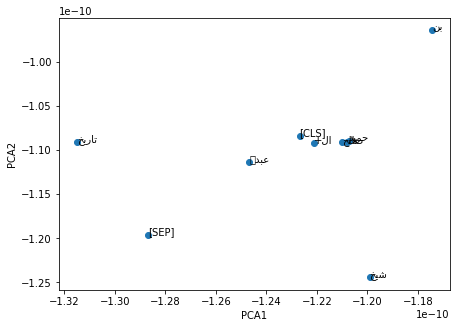

In [ ]:
plt.figure(figsize=(7,5))
labels=tokenized_text
plt.scatter(pca_components[10:20,0],pca_components[10:20,1],cmap='plasma')
for i in range(10,20):
  xword = arabic_reshaper.reshape(labels[i])
  artext = get_display(xword)
  plt.annotate(artext,(pca_components[i,0],pca_components[i,1]))
plt.xlabel("PCA1")
plt.ylabel("PCA2")